#Automated ML mengugnakan TPOT

###Import library dan dataset
Dataset yang digunakan adalah Weather AUS. Pada task ini dilakukan prediksi untuk menentukan apakah besok akan turun hujan atau tidak. Label data adalah RainTomorrow.

In [2]:
# Import library
import datetime as dt
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import seaborn as sn

In [3]:
# Ambil data csv dan tampilkan 5 teratas
df = pd.read_csv('weatherAUS.csv')
df.head()

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,WNW,20.0,24.0,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,No
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,WSW,4.0,22.0,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,No
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,WSW,19.0,26.0,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,No
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,E,11.0,9.0,45.0,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,No
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,NW,7.0,20.0,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,No


In [4]:
# Print jumlah data dan kolom
print("Jumlah data  = ", df.shape[0])
print("Jumlah kolom = ", df.shape[1])

Jumlah data  =  145460
Jumlah kolom =  23


#Preprocessing Data

###Arah Angin
Data arah angin perlu dirubah menjadi derajatnya.

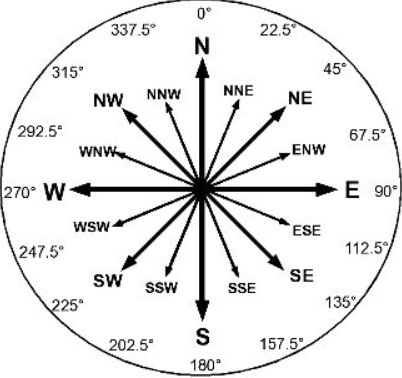

In [5]:
# Inisialisasi arah angin
arah_angin = {'N' : 0, 'NNE' : 22.5, 'NE': 45, 'ENE' : 67.5,
             'E' : 90, 'ESE' : 112.5, 'SE' : 135, 'SSE' : 157.5,
             'S' : 180, 'SSW' : 202.5, 'SW' : 225, 'WSW' : 247.5,
             'W' : 270, 'WNW' : 292.5, 'NW' : 315, 'NNW' : 337.5}

In [6]:
df['WindGustDir'].replace(arah_angin, inplace=True)
df['WindDir9am'].replace(arah_angin, inplace=True)
df['WindDir3pm'].replace(arah_angin, inplace=True)

###Handling Missing Value
Beberapa feature memiliki banyak missing value sehingga perlu melakukan drop pada baris atau kolom. Jika missing value tidak terlalu banyak, nilai yang kosong tersebut bisa diisi dengan perhitungan interpolate, mean atau median nya.

In [7]:
# Cari missing value
percent_missing = df.isnull().sum() * 100 / len(df)
data = {'column_name': df.columns, 'percent_missing': round(percent_missing, 2)}
missing_value_df = pd.DataFrame(data)

In [8]:
# Sort misisng value dan tampilkan persentase missing value
missing_value_df.sort_values('percent_missing', inplace=True)
missing_value_df.reset_index(drop=True, inplace=True)
missing_value_df

,column_name,percent_missing
0,Date,0.00
1,Location,0.00
2,MaxTemp,0.87
3,MinTemp,1.02
4,Temp9am,1.21
5,WindSpeed9am,1.21
6,Humidity9am,1.82
7,WindSpeed3pm,2.11
8,Rainfall,2.24
9,RainToday,2.24


* Baris yang memiliki missing value pada kolom 'RainTomorrow' dan 'RainToday' akan di drop, karena kolom tersebut merupakan label data.

In [9]:
df.dropna(subset=['RainTomorrow', 'RainToday'], inplace=True)

* Kolom 'Sunshine' dan 'Evaporation' memiliki persentase missing value yang tinggi, sehingga bisa dilakukan drop kolom pada kedua kolom tersebut.



In [10]:
# Drop data
df.drop('Evaporation', axis=1, inplace=True)
df.drop('Sunshine', axis=1, inplace=True)

* Untuk kolom dengan missing value yang lain, akan diganti dengan melakukan perhitungan interpolate pada data berdasarkan lokasi
* Data akan di group berdasarkan kolom 'Location' untuk menghindari lokasi yang saling tindih

In [11]:
# Grouping dataframe
df_grouped = df.groupby('Location')
df_location = {}
for key, group in df_grouped:
  df_location[key] = group

In [12]:
# Tampilkan 5 data teratas pada lokasi Albury
df_location['Albury'][:5]

,Date,Location,MinTemp,MaxTemp,Rainfall,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,270.0,44.0,270.0,292.5,20.0,24.0,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,No
1,2008-12-02,Albury,7.4,25.1,0.0,292.5,44.0,337.5,247.5,4.0,22.0,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,No
2,2008-12-03,Albury,12.9,25.7,0.0,247.5,46.0,270.0,247.5,19.0,26.0,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,No
3,2008-12-04,Albury,9.2,28.0,0.0,45.0,24.0,135.0,90.0,11.0,9.0,45.0,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,No
4,2008-12-05,Albury,17.5,32.3,1.0,270.0,41.0,67.5,315.0,7.0,20.0,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,No


In [13]:
for lokasi in df_location :
  df_location[lokasi] = df_location[lokasi].interpolate(method = 'linear', limit_direction = 'both')

####Merge Dataframe
Data yang di group berdasarkan lokasi akan dimasukkan lagi ke dataframe asli

In [14]:
# Merge dataframe
df = pd.DataFrame()
for lokasi in df_location:
  df = pd.concat([df, df_location[lokasi]])

In [15]:
df.head()

,Date,Location,MinTemp,MaxTemp,Rainfall,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
96320,2008-07-01,Adelaide,8.8,15.7,5.0,315.0,48.0,225.0,270.0,13.0,15.0,92.0,67.0,1017.4,1017.7,NaN,NaN,13.5,14.9,Yes,No
96321,2008-07-02,Adelaide,12.7,15.8,0.8,225.0,35.0,202.5,225.0,13.0,15.0,75.0,52.0,1022.4,1022.6,NaN,NaN,13.7,15.5,No,No
96322,2008-07-03,Adelaide,6.2,15.1,0.0,270.0,20.0,22.5,225.0,2.0,11.0,81.0,56.0,1027.8,1026.5,NaN,NaN,9.3,13.9,No,No
96323,2008-07-04,Adelaide,5.3,15.9,0.0,22.5,30.0,22.5,45.0,6.0,13.0,71.0,46.0,1028.7,1025.6,NaN,NaN,10.2,15.3,No,No
96326,2008-07-07,Adelaide,7.6,11.2,16.2,247.5,46.0,292.5,225.0,17.0,13.0,83.0,88.0,1015.9,1017.9,NaN,NaN,9.8,9.3,Yes,Yes


* Sisa dari missing value akan diganti dengan mean dan median nya.
* Mean digunakan untuk data yang bersifat kontinu seeprti 'Pressure9pm', median digunakan untuk data yang bersifat kategorial seperti 'WindGustDir'

In [16]:
df.isnull().sum()

Date                 0
Location             0
MinTemp              0
MaxTemp              0
Rainfall             0
WindGustDir       5925
WindGustSpeed     5925
WindDir9am           0
WindDir3pm           0
WindSpeed9am         0
WindSpeed3pm         0
Humidity9am          0
Humidity3pm          0
Pressure9am      11597
Pressure3pm      11597
Cloud9am         33534
Cloud3pm         33534
Temp9am              0
Temp3pm              0
RainToday            0
RainTomorrow         0
dtype: int64

In [17]:
df['WindGustDir'].fillna((df['WindGustDir'].median()), inplace=True)
df['WindGustSpeed'].fillna((df['WindGustSpeed'].mean()), inplace=True)
df['Pressure9am'].fillna((df['Pressure9am'].mean()), inplace=True)
df['Pressure3pm'].fillna((df['Pressure3pm'].mean()), inplace=True)
df['Cloud9am'].fillna((df['Cloud9am'].mean()), inplace=True)
df['Cloud3pm'].fillna((df['Cloud3pm'].mean()), inplace=True)

* Handling misisng value selesai

In [18]:
df.head()

,Date,Location,MinTemp,MaxTemp,Rainfall,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
96320,2008-07-01,Adelaide,8.8,15.7,5.0,315.0,48.0,225.0,270.0,13.0,15.0,92.0,67.0,1017.4,1017.7,4.661781,4.532815,13.5,14.9,Yes,No
96321,2008-07-02,Adelaide,12.7,15.8,0.8,225.0,35.0,202.5,225.0,13.0,15.0,75.0,52.0,1022.4,1022.6,4.661781,4.532815,13.7,15.5,No,No
96322,2008-07-03,Adelaide,6.2,15.1,0.0,270.0,20.0,22.5,225.0,2.0,11.0,81.0,56.0,1027.8,1026.5,4.661781,4.532815,9.3,13.9,No,No
96323,2008-07-04,Adelaide,5.3,15.9,0.0,22.5,30.0,22.5,45.0,6.0,13.0,71.0,46.0,1028.7,1025.6,4.661781,4.532815,10.2,15.3,No,No
96326,2008-07-07,Adelaide,7.6,11.2,16.2,247.5,46.0,292.5,225.0,17.0,13.0,83.0,88.0,1015.9,1017.9,4.661781,4.532815,9.8,9.3,Yes,Yes


### Normalization
Data yang bersifat kategorial akan direpresentasikan menjadi angka, dan untuk data bersifat kontinu dilakukan MinMaxScaler karena label bersifat biner.

####Date
Tanggal dikelompokkan menjadi 4 musim (dingin, semi, gugur, panas) sehingga kolom 'Date' menjadi data kategorial dengan pembagian:


* Musim dingin = 0 
* Musim semi = 1
* Musim gugur = 2 
* Musim panas = 3



In [19]:
month = df['Date'].apply(lambda x:  dt.datetime.strptime(x,'%Y-%m-%d'))
season = month.dt.month%12 // 3
df['Date'] = season

####Encoding

Kolom 'Location', 'RainToday', 'RainTomorrow' akan direpresentasikan menjadi angka

In [20]:
# Merubah semua kolom tipe 'object' menjadi 'category'
object_column = df.select_dtypes(['object']).columns

category_column = df.select_dtypes(['category']).columns
df[object_column]=df[object_column].apply(lambda x: x.astype('category'))

# Merubah data 'category' menjad representasi angka nya
df[object_column] = df[object_column].apply(lambda x: x.cat.codes)
df[category_column] = df[category_column].apply(lambda x: x.cat.codes)

* Memisah label dengan feature

In [21]:
df_label = df['RainTomorrow']
df_feature = df.drop('RainTomorrow', axis=1)

####Min-Max Scaler
Data akan di normalisasi menggunakan fungsi Min-Max, agar data memiliki rentang yang sama yaitu 0-1 sebagai input model machine learning.

In [22]:
normalize = MinMaxScaler()
df_feature = pd.DataFrame(normalize.fit_transform(df_feature.values), columns=df_feature.columns, index=df_feature.index)
df_feature

,Date,Location,MinTemp,MaxTemp,Rainfall,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday
96320,0.666667,0.0,0.408019,0.387524,0.013477,0.933333,0.325581,0.666667,0.800000,0.100000,0.172414,0.92,0.67,0.609917,0.6496,0.517976,0.503646,0.436709,0.389635,1.0
96321,0.666667,0.0,0.500000,0.389414,0.002156,0.666667,0.224806,0.600000,0.666667,0.100000,0.172414,0.75,0.52,0.692562,0.7280,0.517976,0.503646,0.440928,0.401152,0.0
96322,0.666667,0.0,0.346698,0.376181,0.000000,0.800000,0.108527,0.066667,0.666667,0.015385,0.126437,0.81,0.56,0.781818,0.7904,0.517976,0.503646,0.348101,0.370441,0.0
96323,0.666667,0.0,0.325472,0.391304,0.000000,0.066667,0.186047,0.066667,0.133333,0.046154,0.149425,0.71,0.46,0.796694,0.7760,0.517976,0.503646,0.367089,0.397313,0.0
96326,0.666667,0.0,0.379717,0.302457,0.043666,0.733333,0.310078,0.866667,0.666667,0.130769,0.149425,0.83,0.88,0.585124,0.6528,0.517976,0.503646,0.358650,0.282150,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
108565,0.666667,1.0,0.332547,0.463138,0.000000,0.000000,0.108527,0.266667,0.333333,0.069231,0.080460,0.61,0.28,0.786777,0.7808,0.000000,0.740741,0.386076,0.472169,0.0
108566,0.666667,1.0,0.337264,0.466919,0.000000,0.200000,0.124031,0.333333,0.333333,0.084615,0.103448,0.52,0.22,0.783471,0.7680,0.111111,0.703704,0.386076,0.470250,0.0
108567,0.666667,1.0,0.384434,0.449905,0.000000,0.066667,0.193798,0.200000,1.000000,0.100000,0.195402,0.48,0.37,0.748760,0.7216,0.888889,0.666667,0.386076,0.449136,0.0
108568,0.666667,1.0,0.389151,0.516068,0.000000,1.000000,0.209302,0.000000,0.933333,0.100000,0.172414,0.57,0.31,0.669421,0.6576,0.777778,0.333333,0.394515,0.516315,0.0


###Handling Outlier & Skewed Data


In [23]:
df_feature.skew(axis=0)

Date             0.008973
Location         0.017175
MinTemp          0.025458
MaxTemp          0.229677
Rainfall         9.888061
WindGustDir     -0.073708
WindGustSpeed    0.870441
WindDir9am       0.041814
WindDir3pm      -0.063602
WindSpeed9am     0.770312
WindSpeed3pm     0.669827
Humidity9am     -0.489222
Humidity3pm      0.041912
Pressure9am     -0.085952
Pressure3pm     -0.049243
Cloud9am        -0.375077
Cloud3pm        -0.239389
Temp9am          0.085872
Temp3pm          0.223974
RainToday        1.327992
dtype: float64

* Kolom 'Rainfall' masih memiliki skewness tinggi, sehingga perlu di handle

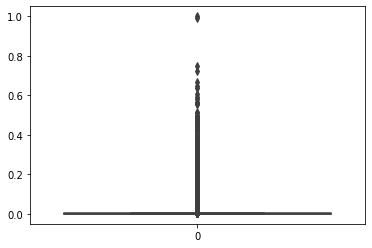

In [24]:
# Visualisasi boxplot kolom 'Rainfall'
sn.boxplot(data = df_feature['Rainfall'])

(array([1.39356e+05, 1.09300e+03, 2.34000e+02, 5.90000e+01, 2.90000e+01,
        8.00000e+00, 4.00000e+00, 2.00000e+00, 0.00000e+00, 2.00000e+00]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

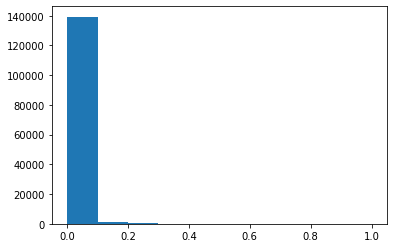

In [25]:
plt.hist(df_feature['Rainfall'])

In [26]:
df_feature['Rainfall'] = np.where(df_feature['Rainfall'] <df_feature['Rainfall'].quantile(0.10), df_feature['Rainfall'].quantile(0.10),df_feature['Rainfall'])
df_feature['Rainfall'] = np.where(df_feature['Rainfall'] >df_feature['Rainfall'].quantile(0.90), df_feature['Rainfall'].quantile(0.90),df_feature['Rainfall'])
print(df_feature['Rainfall'].skew())

1.8213705015214394


(array([102967.,   6373.,   4098.,   3110.,   2403.,   1987.,   1700.,
          1413.,   1265.,  15471.]),
 array([0.        , 0.00161725, 0.0032345 , 0.00485175, 0.006469  ,
        0.00808625, 0.0097035 , 0.01132075, 0.01293801, 0.01455526,
        0.01617251]),
 <a list of 10 Patch objects>)

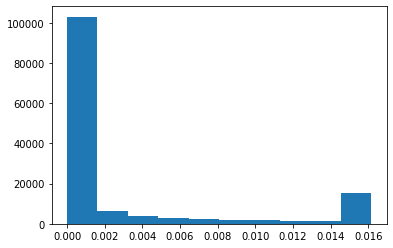

In [27]:
plt.hist(df_feature['Rainfall'])

* Handling outlier dan skewed data selesai

#Imbalanced Classifier
Label memiliki jumlah nilai yang tidak seimbang. Hal ini dapat mempengaruhi tingkat efisiensi model.

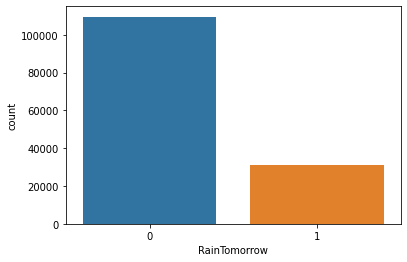

In [28]:
sn.countplot(x = df_label)

* Menggunakan metode SMOTE untuk mengimbangi label. Metode ini menambah data minoritas dengan metode over sampling, sehingga pesebaran data menjadi rata

In [29]:
from imblearn import over_sampling

X = df_feature
y = df_label

X_over_smote, y_over_smote = over_sampling.SMOTE().fit_resample(X, y)
y_over_smote = y_over_smote.reshape(-1,1)

/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [30]:
df = pd.DataFrame(X_over_smote,columns=X.columns)
df["RainTomorrow"] = y_over_smote

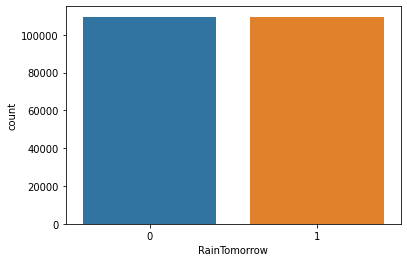

In [31]:
sn.countplot(x = df["RainTomorrow"])

#Save Clean Dataset
Dataframe yang sudah bersih disimpan kedalam bentuk .csv

In [32]:
df.to_csv('weatherAUS_clean.csv')

#Pemodelan Data


###Split Dataset
Dataset dipisah untuk training dan testing

In [33]:
from sklearn.model_selection import train_test_split 
y = df["RainTomorrow"] # y merupakan label
X = df.drop("RainTomorrow", axis=1) # X merupakan feature-feature data (tidak termasuk label)

# Memisah dataset menjadi 60% data train dan 40% data test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.4)

###TPOT
TPOT adalah library autoML yang menerapkan algoritma genetika. TPOT digunakan karena mampu menemukan algoritma naive ML yang ampuh dalam melakukan prediksi atau klasifikasi. Arsitektur dari TPOT dapat dilihat pada ilustrasi berikut.

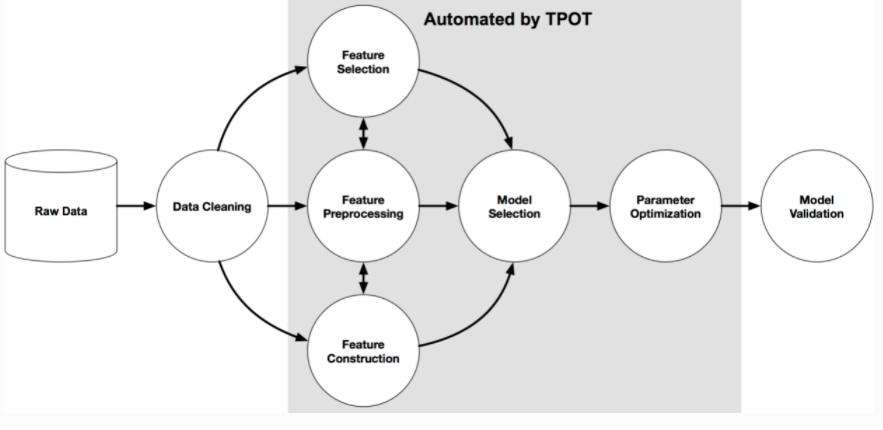

In [ ]:
!pip install TPOT

In [35]:
from tpot import TPOTClassifier, TPOTRegressor

# Generasi berjumlah 3 dan ukuran populasi berjumlah 10. Jumlah ini dikarenakan keterbatasan hardware yang tersedia
tpot = TPOTClassifier(generations=3, population_size=10)
tpot.fit(X_train, y_train)

TPOTClassifier(config_dict=None, crossover_rate=0.1, cv=5,
               disable_update_check=False, early_stop=None, generations=3,
               log_file=None, max_eval_time_mins=5, max_time_mins=None,
               memory=None, mutation_rate=0.9, n_jobs=1, offspring_size=None,
               periodic_checkpoint_folder=None, population_size=10,
               random_state=None, scoring=None, subsample=1.0, template=None,
               use_dask=False, verbosity=0, warm_start=False)

In [36]:
print("Accuracy is {}%".format(round(tpot.score(X_test, y_test), 2)*100))

Accuracy is 90.0%


In [37]:
tpot.export('weather_aus_tpot.py')
!cat weather_aus_tpot.py

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier

# NOTE: Make sure that the outcome column is labeled 'target' in the data file
tpot_data = pd.read_csv('PATH/TO/DATA/FILE', sep='COLUMN_SEPARATOR', dtype=np.float64)
features = tpot_data.drop('target', axis=1)
training_features, testing_features, training_target, testing_target = \
            train_test_split(features, tpot_data['target'], random_state=None)

# Average CV score on the training set was: 0.8962989514631937
exported_pipeline = XGBClassifier(learning_rate=1.0, max_depth=4, min_child_weight=17, n_estimators=100, n_jobs=1, subsample=0.8500000000000001, verbosity=0)

exported_pipeline.fit(training_features, training_target)
results = exported_pipeline.predict(testing_features)


#Kesimpulan
TPOT mampu memberikan hasil yang sangat baik dalam klasifikasi data dengan jumlah besar. Namun daya komputasi dari TPOT sangat besar sehingga memerlukan waktu yang sangat lama. 